In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from typing import List, Optional, Union
from typing import Tuple
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm

def set_seed(seed=42):
    # Python built-in random
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

# Call this at the beginning of your script
set_seed(42)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 2048
EPOCHS = 500 # Set the total number of epochs you want to train for
print(f"✅ Using device: {device}")

✅ Using device: cuda


In [3]:
df_train = pd.read_csv("./KDD/KDDTrain.csv")
#df_train = df_train.drop(columns=['service', 'protocol_type','flag'])
df_train['label'] = df_train['label'].apply(lambda x: 0 if x == 'normal' else 1)
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [4]:
df_test = pd.read_csv("./KDD/KDDTest.csv")
#df_test = df_test.drop(columns=['service', 'protocol_type','flag'])
df_test['label'] = df_test['label'].apply(lambda x: 0 if x == 'normal' else 1)
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,0
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,1
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,1


In [5]:
# Columns you want to encode instead of dropping
encode_cols = ['service', 'protocol_type', 'flag']

label_encoders = {}
for col in encode_cols:
    le = LabelEncoder()
    # Fit on combined train + test to ensure consistency
    combined_data = pd.concat([df_train[col], df_test[col]], axis=0)
    le.fit(combined_data)

    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

    label_encoders[col] = le  # Save encoder for later use

In [6]:
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,20,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,2,44,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,1,49,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,1,24,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,1,24,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [7]:
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,49,1,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1
1,0,1,49,1,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1
2,2,1,20,9,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,0
3,0,0,14,9,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,1
4,1,1,60,2,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,1


In [8]:
X_train = df_train.drop(['label'], axis=1)
y_train = df_train['label']

X_test = df_test.drop(['label'], axis=1)
y_test = df_test['label']

X_train = X_train.loc[:, (X_train >= 0).all()]
X_train = np.log1p(X_train)

X_test = X_test.loc[:, (X_test >= 0).all()]
X_test = np.log1p(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("x_train shape:",X_train_scaled.shape,"| y_train shape:",y_train.shape,"| x_test shape:",X_test_scaled.shape,"| y_test shape:",y_test.shape)

x_train shape: (125973, 41) | y_train shape: (125973,) | x_test shape: (22544, 41) | y_test shape: (22544,)


In [9]:
x_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
x_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [10]:
class IndexedDataset(Dataset):
    def __init__(self, X_tensor, y_tensor):
        self.X = X_tensor
        self.y = y_tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], idx

train_dataset = IndexedDataset(x_train_tensor,y_train_tensor)
test_dataset = IndexedDataset(x_test_tensor,y_test_tensor)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size)

# Initialize per-sample weights (1.0 for all)
sample_weights = torch.ones(len(x_train_tensor), dtype=torch.float32)
sample_weights = sample_weights.to(device)

In [11]:
class ActivationNet(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        self.layer1 = nn.Linear(num_features, 32)
        self.y0_head = nn.Linear(32, 1)
        self.m_head  = nn.Linear(32, 1)
        self.x0_head = nn.Linear(32, 1)
        self.combine = nn.Linear(3, 3)

    def forward(self, x):
        h = self.layer1(x)
        h = torch.tanh(h)
        
        y0 = self.y0_head(h)
        m  = self.m_head(h)
        x0 = self.x0_head(h)
        
        params = torch.cat([y0, m, x0], dim=-1)
        params = self.combine(params)
        
        y0, m, x0 = params[:,0:1], params[:,1:2], params[:,2:3]
        
        y = y0 + m * (x - x0)
        return [x, y], [x0, y0, m]

In [12]:
class KDD_Model(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.layer1 = nn.Linear(input_features, 128)
        self.bn1 = nn.BatchNorm1d(num_features=128)
        self.activation1 = ActivationNet(num_features=128)

        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        self.activation2 = ActivationNet(num_features=64)
        
        self.layer3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(num_features=32)
        self.activation3 = ActivationNet(num_features=32)

        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.bn1(self.layer1(x))
        out1, internal_out1 = self.activation1(x)
        
        x = self.bn2(self.layer2(out1[1]))
        out2, internal_out2 = self.activation2(x)

        x = self.bn3(self.layer3(out2[1]))
        out3, internal_out3 = self.activation3(x)

        x = self.output_layer(out3[1])
        return x, [out1, out2, out3], [internal_out1, internal_out2, internal_out3]

In [13]:
# --- File Paths ---
BEST_MODEL_PATH = "./KDD/results_mv_1d/best_model_f1.pth"
CHECKPOINT_PATH = "./KDD/results_mv_1d/training_checkpoint.pth"
LOGS_PATH = "./KDD/results_mv_1d/training_logs.csv"

In [14]:
input_features = X_train_scaled.shape[1]

model = KDD_Model(input_features)
model = model.to(device)
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='none')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

In [17]:
# Checkpoint Loading (Resume Logic)

THRESH = 0.5  # <- your decision threshold
start_epoch = 0
best_f1_score = 0.0
history = []

# Check if a checkpoint file exists
if os.path.exists(CHECKPOINT_PATH):
    print(f"Checkpoint found! Resuming training from {CHECKPOINT_PATH}")
    # Load the checkpoint
    checkpoint = torch.load(CHECKPOINT_PATH, weights_only=False)
    
    # Restore the state
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']
    
    # Find the best F1 score from the loaded history to continue tracking
    if history:
        # This gets the 'test_f1' value from each dictionary in the history list
        best_f1_score = max([epoch_data.get('test_f1', 0) for epoch_data in history])
    
    print(f"Resuming from epoch {start_epoch}. Best Test F1 so far: {best_f1_score:.4f}")
else:
    print("No checkpoint found. Starting training from scratch.")

Checkpoint found! Resuming training from ./KDD/results_mv_1d/training_checkpoint.pth
Resuming from epoch 500. Best Test F1 so far: 0.9281


In [18]:
def update_sample_weights(
    model: nn.Module,
    data_loader: DataLoader,
    current_weights: torch.Tensor,
    device: torch.device,
    threshold: float = 0.5,
    increase_factor: float = 1.2,
    decrease_factor: float = 0.9,
    min_weight: float = 0.1,
    max_weight: float = 5.0
) -> torch.Tensor:

    model.eval()  # Set model to evaluation mode for consistent predictions
    
    all_preds = []
    all_labels = []
    all_indices = []
    
    with torch.no_grad():
        # Loop through the entire dataset to get predictions
        for inputs, labels, indices in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs, _, _ = model(inputs)
            preds = (torch.sigmoid(outputs) > threshold).float()
            
            all_preds.append(preds.view(-1))
            all_labels.append(labels.view(-1))
            all_indices.append(indices.to(device)) # Keep indices on the same device
            
    # Concatenate all batch results into single tensors
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_indices = torch.cat(all_indices)

    # Identify incorrect and correct predictions using a boolean mask
    incorrect_mask = (all_preds != all_labels)
    correct_mask = ~incorrect_mask

    # Use the boolean masks to get the global indices of the samples
    incorrect_indices = all_indices[incorrect_mask]
    correct_indices = all_indices[correct_mask]

    # Update weights for the identified samples
    # Note: We update the original 'current_weights' tensor
    current_weights[incorrect_indices] *= increase_factor
    current_weights[correct_indices] *= decrease_factor
    
    # Clamp the weights to a reasonable range and return
    return current_weights.clamp(min=min_weight, max=max_weight)

In [19]:
# Evaluation Function

@torch.no_grad()
def evaluate_model_threshold(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_count = 0

    all_preds = []
    all_labels = []

    progress_bar = tqdm(data_loader, desc=f"Testing", leave=True)

    for inputs, labels, _ in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device).view(-1).long()
        outputs, _, _ = model(inputs)

        # logits -> probs
        probs = torch.sigmoid(outputs.view(-1))
        preds = (probs >= THRESH).long()

        # per-sample loss (no weights on test unless you have a test weight vector)
        losses = loss_fn(outputs.view(-1), labels.float()).mean()

        batch_size = labels.size(0)
        total_loss += losses.item() * batch_size
        total_count += batch_size

        all_preds.append(preds.detach().cpu())
        all_labels.append(labels.detach().cpu())

        progress_bar.set_postfix(loss=total_loss / total_count)

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Accuracy via thresholded preds
    acc = (all_preds == all_labels).mean()

    # Macro P/R/F1 (over classes 0 and 1)
    p, r, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    avg_loss = total_loss / total_count
    return avg_loss, acc, p, r, f1

In [20]:
# ---------------- Main Training Loop ----------------
for epoch in range(start_epoch, EPOCHS):
    model.train()

    # running stats for TRAIN (weighted loss averaged by total weight)
    total_weighted_loss = 0.0
    total_count = 0.0

    train_all_preds = []
    train_all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)

    for inputs, labels, indices in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device).view(-1).long()
        indices = indices.to(device)

        # ---- Forward ----
        outputs, _, _ = model(inputs)  # shape [B, 1] or [B]
        logits = outputs.view(-1)
        probs = torch.sigmoid(logits)
        preds = (probs >= THRESH).long()

        # per-sample loss (assumes BCEWithLogitsLoss(reduction='none'))
        losses = loss_fn(logits, labels.float()).view(-1)

        # weights
        batch_weights = sample_weights[indices]  # shape [B]
        weighted_loss = (losses * batch_weights).mean()

        # ---- Backward ----
        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()

        # ---- Accumulate epoch stats ----
        batch_size = labels.size(0)
        total_weighted_loss += weighted_loss.item() * batch_size
        total_count += batch_size

        train_all_preds.append(preds.detach().cpu())
        train_all_labels.append(labels.detach().cpu())

        progress_bar.set_postfix(weighted_loss=total_weighted_loss / total_count)

    # Update weights: increase for misclassified
    sample_weights = update_sample_weights(
        model=model,
        data_loader=train_loader,
        current_weights=sample_weights,
        device=device,
        threshold=THRESH
    )

    # ---- TRAIN epoch metrics (threshold-based) ----
    train_all_preds = torch.cat(train_all_preds).numpy()
    train_all_labels = torch.cat(train_all_labels).numpy()

    train_weighted_loss = total_weighted_loss / total_count
    train_acc = (train_all_preds == train_all_labels).mean()
    train_p, train_r, train_f1, _ = precision_recall_fscore_support(
        train_all_labels, train_all_preds, average='macro', zero_division=0
    )

    # ---- TEST evaluation (single pass, threshold-based) ----
    test_loss, test_acc, test_p, test_r, test_f1 = evaluate_model_threshold(
        model, test_loader, loss_fn, device
    )

    # ---- Logging ----
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_weighted_loss:.4f}, Acc(th={THRESH}): {train_acc:.4f}, "
        f"P: {train_p:.4f}, R: {train_r:.4f}, F1: {train_f1:.4f} | "
        f"Test Loss: {test_loss:.4f}, Acc(th={THRESH}): {test_acc:.4f}, "
        f"P: {test_p:.4f}, R: {test_r:.4f}, F1: {test_f1:.4f}"
    )

    epoch_data = {
        'epoch': epoch + 1,
        'train_loss': train_weighted_loss,
        'train_accuracy_threshold': train_acc,
        'train_precision': train_p,
        'train_recall': train_r,
        'train_f1': train_f1,
        'test_loss': test_loss,
        'test_accuracy_threshold': test_acc,
        'test_precision': test_p,
        'test_recall': test_r,
        'test_f1': test_f1,
        'threshold': THRESH,
    }
    history.append(epoch_data)
    pd.DataFrame(history).to_csv(LOGS_PATH, index=False)

    # ---- Save the Best Model by Test F1 ----
    if test_f1 > best_f1_score:
        best_f1_score = test_f1
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"🎉 New best model saved with Test F1 Score: {best_f1_score:.4f}")

    # ---- Checkpoint every epoch ----
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
    }, CHECKPOINT_PATH)

print("="*60)
print("Training finished!")
print(f"Best model saved to: {BEST_MODEL_PATH} (Test F1: {best_f1_score:.4f})")
print(f"Full training logs saved to: {LOGS_PATH}")
print(f"Final checkpoint for resumption saved to: {CHECKPOINT_PATH}")

Training finished!
Best model saved to: ./KDD/results_mv_1d/best_model_f1.pth (Test F1: 0.9281)
Full training logs saved to: ./KDD/results_mv_1d/training_logs.csv
Final checkpoint for resumption saved to: ./KDD/results_mv_1d/training_checkpoint.pth


In [22]:
# Read the CSV file
df = pd.read_csv(LOGS_PATH)

# Find the index of the row with the best (maximum) test F1 score
best_idx = df['test_f1'].idxmax()

# Get the entire row
best_row = df.loc[best_idx]

# Print the entire row with all columns
print("=== 🏆 Best F1 Score Row ===")
print(best_row)

# If you also want it in a single line (e.g., for logging or CSV export)
print("\n=== Single-line view ===")
print(best_row.to_dict())


=== 🏆 Best F1 Score Row ===
epoch                       111.000000
train_loss                    0.017083
train_accuracy_threshold      0.984243
train_precision               0.983865
train_recall                  0.984555
train_f1                      0.984179
test_loss                     0.283210
test_accuracy_threshold       0.928983
test_precision                0.926171
test_recall                   0.931547
test_f1                       0.928106
threshold                     0.500000
Name: 110, dtype: float64

=== Single-line view ===
{'epoch': 111.0, 'train_loss': 0.0170829291649625, 'train_accuracy_threshold': 0.98424265517214, 'train_precision': 0.9838646699051756, 'train_recall': 0.9845547498404568, 'train_f1': 0.9841786886756604, 'test_loss': 0.2832101266262716, 'test_accuracy_threshold': 0.9289833215046132, 'test_precision': 0.9261714611872074, 'test_recall': 0.9315466695278156, 'test_f1': 0.9281055512458593, 'threshold': 0.5}


In [ ]:
# (torch.rand(num_points) * 2 * x_max) - x_max for _ in range(act.num_features)
# torch.linspace(x_min, x_max, num_points) for _ in range(act.num_features)
# torch.linspace(x_min, x_max, num_points) + ((torch.rand(num_points) * 2 * 1) - 1) for _ in range(act.num_features)

def plot_chain_activations(model, x_min=-100, x_max=100, num_points=512, select_features=[0,1,2,3]):
    activations = [m for m in model.modules() if isinstance(m, ActivationNet)]

    for i, act in enumerate(activations, 1):
        # prepare input: each feature gets the same linspace
        xs = torch.stack([
            torch.linspace(x_min, x_max, num_points) + ((torch.rand(num_points) * 2 * 1) - 1) for _ in range(act.num_features)
        ], dim=1).to(device)   # [num_points, num_features]

        out, internal_out = act(xs)
        ys = out[1]
        ys = ys.detach().cpu().numpy()
        xs = xs.detach().cpu().numpy()

        int_xs, int_ys, _ = internal_out
        int_ys = int_ys.detach().cpu().numpy()[:,0]
        int_xs = int_xs.detach().cpu().numpy()[:,0]

        # new figure for each activation
        plt.figure(figsize=(6, 4))
        for k in select_features:
            if k < act.num_features:  # avoid index error
                plt.scatter(xs[:, k], ys[:, k], label=f"feature {k}")

        plt.scatter(int_xs, int_ys, marker="+", color="red", label=f"column")
        
        # Number of points to select
        select_k_points = 5
        indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
        # Prepare x and y pairs for all segments
        gen_data_X = np.column_stack([int_xs[indices], xs[indices, k]]).T   # shape (2, k)
        gen_pred_Y = np.column_stack([int_ys[indices], ys[indices, k]]).T   # shape (2, k)
        # Plot all segments at once
        plt.plot(gen_data_X, gen_pred_Y, color="orange")

        plt.axhline(0, color="k", linewidth=0.5)
        plt.axvline(0, color="k", linewidth=0.5)
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.title(f"ActivationNet {i} functions")
        plt.show()

if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)
model.eval()

plot_chain_activations(model, x_min=-100, x_max=100, num_points=512, select_features=[0,1,2,3])

In [16]:
def plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0]):
    """
    Plot activations of ActivationNet modules using data flowing through the model on test_loader.
    Uses forward hooks to capture inputs and outputs of ActivationNet layers.
    """
    model.eval()
    device = next(model.parameters()).device

    # Collect activation modules
    activations = [m for m in model.modules() if isinstance(m, ActivationNet)]
    act_inputs, act_outputs = [], []

    # Hook to capture activations
    def hook_fn(module, inputs, outputs):
        act_inputs.append(inputs[0].detach().cpu())
        main_out, internal_out = outputs
        y = main_out[1]
        int_x, int_y, _ = internal_out
        act_outputs.append([y.detach().cpu(), int_x.detach().cpu(), int_y.detach().cpu()])

    # Register hooks
    hooks = []
    for act in activations:
        hooks.append(act.register_forward_hook(hook_fn))

    # Run model on test batches
    for batch_idx, (inputs, _, _) in enumerate(test_loader):
        if batch_idx >= num_batches:
            break

        inputs = inputs.to(device)
        with torch.no_grad():
            _ = model(inputs)  # forward pass, hooks will store activations

        # Plot each ActivationNet
        for i, (xs, act_output) in enumerate(zip(act_inputs, act_outputs), 1):
            ys, int_xs, int_ys = act_output
            xs, ys = xs.numpy(), ys.numpy()
            int_xs, int_ys = int_xs.numpy()[:, 0], int_ys.numpy()[:, 0]

            plt.figure(figsize=(6, 4))
            for k in select_features:
                if k < xs.shape[1]:  # avoid index errors
                    plt.scatter(xs[:, k], ys[:, k], s=10, alpha=0.6, label=f"feature {k}")

            plt.scatter(int_xs, int_ys, marker="+", color="red", label=f"column")

            # Number of points to select
            select_k_points = 5
            indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
            # Prepare x and y pairs for all segments
            gen_data_X = np.column_stack([int_xs[indices], xs[indices, k]]).T   # shape (2, k)
            gen_pred_Y = np.column_stack([int_ys[indices], ys[indices, k]]).T   # shape (2, k)
            # Plot all segments at once
            plt.plot(gen_data_X, gen_pred_Y, color="orange")
            
            plt.axhline(0, color="k", linewidth=0.5)
            plt.axvline(0, color="k", linewidth=0.5)
            plt.legend()
            plt.xlabel("x (pre-activation input)")
            plt.ylabel("f(x) (activation output)")
            plt.title(f"ActivationNet {i} – Batch {batch_idx}")
            plt.show()

        # Clear after each batch to avoid accumulation
        act_inputs.clear()
        act_outputs.clear()

    # Remove hooks after plotting
    for h in hooks:
        h.remove()


if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)

plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0, 1, 2, 3])

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

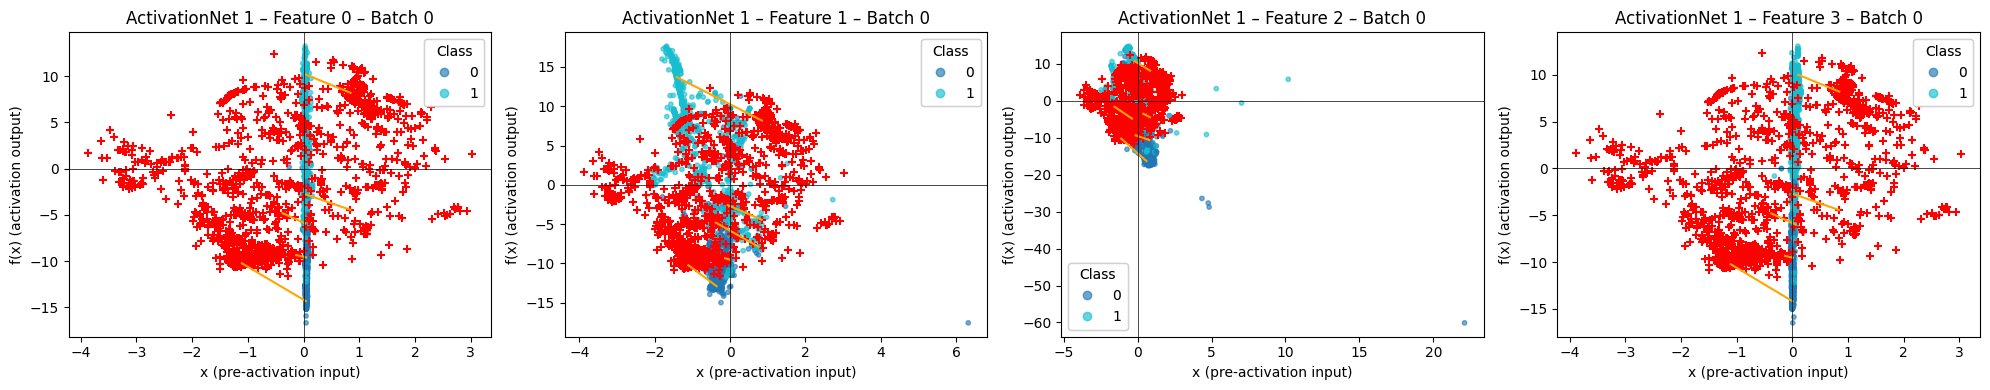

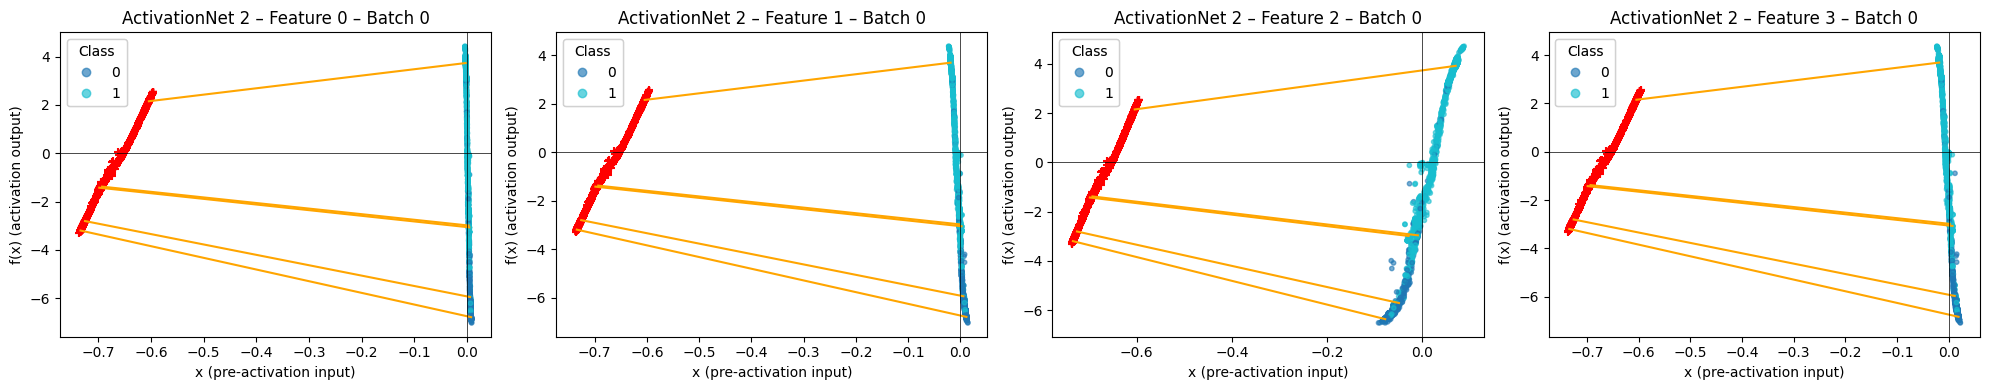

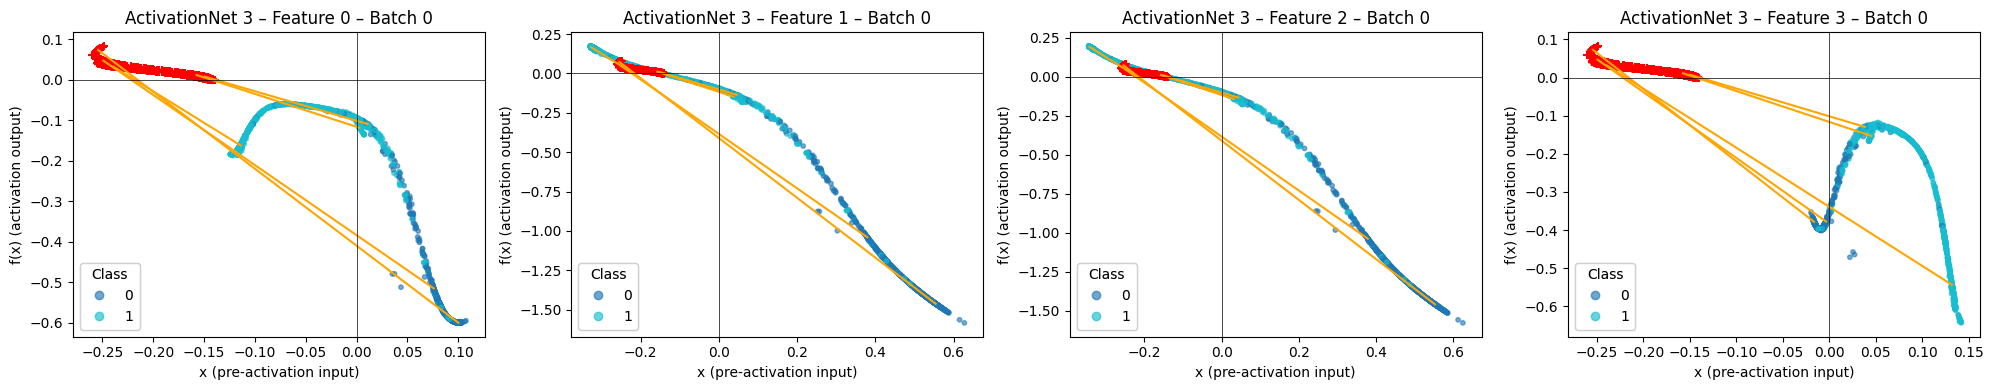

In [103]:
def plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0], color_by_class=False):
    """
    Plot activations of ActivationNet modules using data flowing through the model on test_loader.
    Each selected feature gets its own subplot instead of all being in one plot.

    Args:
        model: Trained KDD_Model instance
        test_loader: DataLoader with test dataset
        num_batches: Number of batches to visualize
        select_features: List of feature indices to plot
        color_by_class: If True, color points by class label from dataset
    """
    model.eval()
    device = next(model.parameters()).device

    # Collect activation modules
    activations = [m for m in model.modules() if isinstance(m, ActivationNet)]
    act_inputs, act_outputs = [], []

    # Hook to capture activations
    def hook_fn(module, inputs, outputs):
        act_inputs.append(inputs[0].detach().cpu())
        main_out, internal_out = outputs
        y = main_out[1]
        int_x, int_y, _ = internal_out
        act_outputs.append([y.detach().cpu(), int_x.detach().cpu(), int_y.detach().cpu()])

    # Register hooks
    hooks = [act.register_forward_hook(hook_fn) for act in activations]

    # Run model on test batches
    for batch_idx, (inputs, labels, _) in enumerate(test_loader):  # assuming dataset returns (x, y, extra)
        if batch_idx >= num_batches:
            break

        inputs = inputs.to(device)
        labels = labels.cpu().numpy() if color_by_class else None

        with torch.no_grad():
            _ = model(inputs)  # forward pass, hooks will store activations

        # Plot each ActivationNet
        for i, (xs, act_output) in enumerate(zip(act_inputs, act_outputs), 1):
            ys, int_xs, int_ys = act_output
            xs, ys = xs.numpy(), ys.numpy()
            int_xs, int_ys = int_xs.numpy()[:, 0], int_ys.numpy()[:, 0]

            feats = [k for k in select_features if k < xs.shape[1]]
            n_feats = len(feats)
            if n_feats == 0:
                continue

            fig, axes = plt.subplots(1, n_feats, figsize=(5 * n_feats, 4), squeeze=False)

            for j, k in enumerate(feats):
                ax = axes[0, j]

                if color_by_class and labels is not None:
                    scatter = ax.scatter(xs[:, k], ys[:, k], c=labels, cmap="tab10", s=10, alpha=0.6)

                    ax.scatter(int_xs, int_ys, marker="+", color="red", label=f"column")

                    # Number of points to select
                    select_k_points = 5
                    indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
                    # Prepare x and y pairs for all segments
                    gen_data_X = np.column_stack([int_xs[indices], xs[indices, k]]).T   # shape (2, k)
                    gen_pred_Y = np.column_stack([int_ys[indices], ys[indices, k]]).T   # shape (2, k)
                    # Plot all segments at once
                    ax.plot(gen_data_X, gen_pred_Y, color="orange")
                    
                    legend1 = ax.legend(*scatter.legend_elements(), title="Class")
                    ax.add_artist(legend1)
                else:
                    ax.scatter(xs[:, k], ys[:, k], s=10, alpha=0.6, label=f"feature {k}")

                    ax.scatter(int_xs, int_ys, marker="+", color="red", label=f"column")

                    # Number of points to select
                    select_k_points = 5
                    indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
                    # Prepare x and y pairs for all segments
                    gen_data_X = np.column_stack([int_xs[indices], xs[indices, k]]).T   # shape (2, k)
                    gen_pred_Y = np.column_stack([int_ys[indices], ys[indices, k]]).T   # shape (2, k)
                    # Plot all segments at once
                    ax.plot(gen_data_X, gen_pred_Y, color="orange")
                    
                    ax.legend()

                ax.axhline(0, color="k", linewidth=0.5)
                ax.axvline(0, color="k", linewidth=0.5)
                ax.set_xlabel("x (pre-activation input)")
                ax.set_ylabel("f(x) (activation output)")
                ax.set_title(f"ActivationNet {i} – Feature {k} – Batch {batch_idx}")

            plt.tight_layout()
            plt.show()

        # Clear after each batch to avoid accumulation
        act_inputs.clear()
        act_outputs.clear()

    # Remove hooks after plotting
    for h in hooks:
        h.remove()

if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)

plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0, 1, 2, 3], color_by_class=True)